#  天池新人实战赛o2o优惠券使用预测

> 

# 0. 导入包

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
import os, sys, pickle
import datetime
%matplotlib inline

# 1. EDA 

### 1.1 读入数据

In [2]:
# 读取数据
df_offline = pd.read_csv("../ali-data/ccf_offline_stage1_train.csv")
df_online = pd.read_csv("../ali-data/ccf_online_stage1_train.csv")
df_test = pd.read_csv("../ali-data/ccf_offline_stage1_test_revised.csv")

# offline 文件
df_offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


### 1.2 赛题分析

    User_id        用户id

    Merchant_id     商家id

    Coupon_id	    优惠券id

    Discount_rate	  满x减y

    Distance	    x*500米,user常活动的地点与店铺距离，0：小于500米，10：大于5公里 

    Date_received  	领劵日期

    Date          消费日期
    
> 预测15天内使用优惠卷的概率。

### 1.3 样本数量分布

In [3]:
print("样本总数：",df_offline.shape[0])
print("有卷，且使用:",df_offline[pd.notnull(df_offline["Coupon_id"]) & pd.notnull(df_offline["Date"])].shape[0])

print("有卷，未使用:",df_offline[pd.notnull(df_offline["Coupon_id"]) & pd.isnull(df_offline["Date"])].shape[0])

print("无卷，且购买:",df_offline[pd.isnull(df_offline["Coupon_id"]) & pd.notnull(df_offline["Date"])].shape[0])

print("无卷，未购买:",df_offline[pd.isnull(df_offline["Coupon_id"]) & pd.isnull(df_offline["Date"])].shape[0])

样本总数： 1754884
有卷，且使用: 75382
有卷，未使用: 977900
无卷，且购买: 701602
无卷，未购买: 0


In [4]:
print("测试集")
print("     - 样本数量: ", df_test.shape[0])
print("     - 不重复的用户数量：" ,len(set(df_test["User_id"])))
print("     - 不重复的商家数量：" ,len(set(df_test["Merchant_id"])))

print("训练集")
print("     - 样本数量: ", df_offline.shape[0])
print("     - 不重复的用户数量：" ,len(set(df_offline["User_id"])))
print("     - 不重复的商家数量：" ,len(set(df_offline["Merchant_id"])))

print("同时出现在训练集，测试集中的用户数量：", len(set(df_test["User_id"]) & set(set(df_offline["User_id"]))))


测试集
     - 样本数量:  113640
     - 不重复的用户数量： 76309
     - 不重复的商家数量： 1559
训练集
     - 样本数量:  1754884
     - 不重复的用户数量： 539438
     - 不重复的商家数量： 8415
同时出现在训练集，测试集中的用户数量： 76307


### 1.4 简单分析

1. train & test 有重复出现的用户。
    
       可以针对用户的消费习惯（消费能力，消费倾向的商店，是否喜欢使用优惠券等等）深入挖掘；

2. 存在大量的用户领卷未使用。
        
       为什么领券未使用？领券时间？距离？优惠幅度？优惠类型？
       
3. 未领券，且购买用户也很多，但测试集中只存在领卷的用户。
        
       未领券用户是否也参与用户消费习惯的特征挖掘呢？
       
4. 商家也存在大量重复现象。

       可以针对商家的店铺吸引力（是否有常客，常客使用优惠券比例，店铺活动力度/频率， 客户优惠券使用率，）深入挖掘；
       
5. 线上数据。
   
       线上数据可以挖掘用户消费习惯，店铺吸引力。

# 2. 特征工程

In [5]:
# 合并train 和test，同时做处理
data = pd.concat([df_offline, df_test], keys=(["train", "test"]))

# 可以使用的特征
feature_list = []


# # 拆开数据
# train_data = data2[data2.iloc[:,1]== "train"]
# train_data = train_data.iloc[:,3:]

# test_data = data2[data2.iloc[:,1]== "test"]
# test_data = test_data.iloc[:,3:]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [6]:
data.head()

Coupon_id        Date  Date_received Discount_rate  Distance  \
train 0        NaN  20160217.0            NaN           NaN       0.0   
      1    11002.0         NaN     20160528.0        150:20       1.0   
      2     8591.0         NaN     20160217.0          20:1       0.0   
      3     1078.0         NaN     20160319.0          20:1       0.0   
      4     8591.0         NaN     20160613.0          20:1       0.0   

         Merchant_id  User_id  
train 0         2632  1439408  
      1         4663  1439408  
      2         2632  1439408  
      3         2632  1439408  
      4         2632  1439408

### 2.1 商铺吸引力

#### 2.1.1 领券日期与券使用率的关系

> 观察到，用券消费次数： 周五>周日>周六

编码：

- 1: 周五>周日>周六
- 0: 其他

In [7]:

def date2week(row):
    if pd.isnull(row):
        return 0
    date = pd.to_datetime(row,format="%Y%m%d")
    return date.weekday()+1

data["f_week"] = data["Date_received"].apply(lambda x : date2week(x))


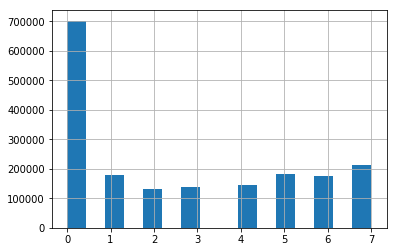

In [8]:
## 收到优惠卷的时间 - 周几

data["f_week"].hist(bins=16)

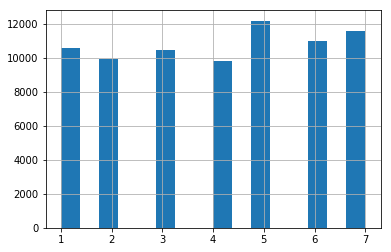

In [9]:
# 不同日期，优惠卷的数量分布

data[pd.notnull(data["Date_received"]) & pd.notnull(data["Date"])]["f_week"].hist(bins=16)

*优惠卷发放日期分布变化不是太明显，周一，周五，周日发放的多一些。*

*周五使用大于周末*

*这种统计也不太严谨*

In [10]:
## 提取特征1： 类别特征-是否是节假日

def isOffDay(row):
    try:
        if row in [5,6,7]:
            return 1
        return 0
    except:
        print("error")

data["f_off_day"] = data["f_week"].apply(lambda x : isOffDay(x))




In [11]:
feature_list.append("f_off_day")
data.head()

Coupon_id        Date  Date_received Discount_rate  Distance  \
train 0        NaN  20160217.0            NaN           NaN       0.0   
      1    11002.0         NaN     20160528.0        150:20       1.0   
      2     8591.0         NaN     20160217.0          20:1       0.0   
      3     1078.0         NaN     20160319.0          20:1       0.0   
      4     8591.0         NaN     20160613.0          20:1       0.0   

         Merchant_id  User_id  f_week  f_off_day  
train 0         2632  1439408       0          0  
      1         4663  1439408       6          1  
      2         2632  1439408       3          0  
      3         2632  1439408       6          1  
      4         2632  1439408       1          0

#### 2.1.2 优惠券类型

> 优惠券的类型有三种：

- 满减      100:5
- 折扣率    0.95
- 无优惠卷

- 类型，one hot 编码
统一转换未折扣率  = 1 - 5/100

In [12]:
def discount_rate(x):
    x = str(x)
    length = len(x)
    a=1
    b=1
    try:
        if length == 3:
            return 1.0
        elif ":" in x:
            a,b = x.split(":")
            return 1-float(b)/float(a)
    except:
        return x

data["f_discount_rate"] = data["Discount_rate"].apply(lambda x : discount_rate(x))

feature_list.append("f_discount_rate")  

In [13]:
##  类型
def discount_cls(x):
    x = str(x)
    length = len(x)
    if length == 3:
        return 3
    elif ":" in x:
        return 1
    else:
        return 2

data["f_discount_cls"] = data["Discount_rate"].copy()
data["f_discount_cls"] = data["f_discount_cls"].apply(lambda x : discount_cls(x))

data[["f_cls_jian", "f_cls_discount","f_cls_None"]]=pd.get_dummies(data["f_discount_cls"])

feature_list.append("f_cls_jian")  
feature_list.append("f_cls_discount")  
feature_list.append("f_cls_None") 

data.head()
    

Coupon_id        Date  Date_received Discount_rate  Distance  \
train 0        NaN  20160217.0            NaN           NaN       0.0   
      1    11002.0         NaN     20160528.0        150:20       1.0   
      2     8591.0         NaN     20160217.0          20:1       0.0   
      3     1078.0         NaN     20160319.0          20:1       0.0   
      4     8591.0         NaN     20160613.0          20:1       0.0   

         Merchant_id  User_id  f_week  f_off_day  f_discount_rate  \
train 0         2632  1439408       0          0         1.000000   
      1         4663  1439408       6          1         0.866667   
      2         2632  1439408       3          0         0.950000   
      3         2632  1439408       6          1         0.950000   
      4         2632  1439408       1          0         0.950000   

         f_discount_cls  f_cls_jian  f_cls_discount  f_cls_None  
train 0               3           0               0           1  
      1               1           1               0           0  
      2               1           1               0           0  
      3               1           1               0           0  
      4               1           1               0           0

#### 保存一下

In [14]:
data.to_csv("../ali-data/feature.csv")

In [15]:
data = pd.read_csv("../ali-data/feature.csv")
data.drop(["Unnamed: 1"],axis=1,inplace=True)
data.head()

,Unnamed: 0,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id,f_week,f_off_day,f_discount_rate,f_discount_cls,f_cls_jian,f_cls_discount,f_cls_None
0,train,NaN,20160217.0,NaN,NaN,0.0,2632,1439408,0,0,1.000000,3,0,0,1
1,train,11002.0,NaN,20160528.0,150:20,1.0,4663,1439408,6,1,0.866667,1,1,0,0
2,train,8591.0,NaN,20160217.0,20:1,0.0,2632,1439408,3,0,0.950000,1,1,0,0
3,train,1078.0,NaN,20160319.0,20:1,0.0,2632,1439408,6,1,0.950000,1,1,0,0
4,train,8591.0,NaN,20160613.0,20:1,0.0,2632,1439408,1,0,0.950000,1,1,0,0


### 2.2 消费者

#### 2.2.1 领劵后的使用率

*领劵未购物次数*

In [16]:
train_data = data[data["Unnamed: 0"]=="train"]

train_data = train_data.drop(["Unnamed: 0"],axis=1)

test_data = data[data["Unnamed: 0"]=="test"]
test_data = test_data.drop(["Unnamed: 0"],axis=1)
test_data.head()

,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id,f_week,f_off_day,f_discount_rate,f_discount_cls,f_cls_jian,f_cls_discount,f_cls_None
1754884,9983.0,NaN,20160712.0,30:5,1.0,450,4129537,2,0,0.833333,1,1,0,0
1754885,3429.0,NaN,20160706.0,30:5,NaN,1300,6949378,3,0,0.833333,1,1,0,0
1754886,6928.0,NaN,20160727.0,200:20,5.0,7113,2166529,3,0,0.900000,1,1,0,0
1754887,1808.0,NaN,20160727.0,100:10,5.0,7113,2166529,3,0,0.900000,1,1,0,0
1754888,6500.0,NaN,20160708.0,30:1,2.0,7605,6172162,5,1,0.966667,1,1,0,0


In [17]:
# data1：领劵未消费数据
coupon_no_used = train_data[pd.notnull(train_data.Coupon_id) & pd.isnull(train_data.Date)]

# data2：领劵且消费数据
coupon_used = train_data[pd.notnull(train_data.Coupon_id) & pd.notnull(train_data.Date)]

# data3; 未领卷且消费
no_coupon = train_data[pd.isnull(train_data.Coupon_id) & pd.notnull(train_data.Date)]

#coupon_no_used.head()

In [18]:
# 统计： 领劵未购物数据量
user_coupon_no_used = coupon_no_used.groupby("User_id")


tmp = user_coupon_no_used.size().reset_index(name="f_coupon_no_used")

data = pd.merge(data,tmp,how="left", on = "User_id")
data.head()

,Unnamed: 0,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id,f_week,f_off_day,f_discount_rate,f_discount_cls,f_cls_jian,f_cls_discount,f_cls_None,f_coupon_no_used
0,train,NaN,20160217.0,NaN,NaN,0.0,2632,1439408,0,0,1.000000,3,0,0,1,4.0
1,train,11002.0,NaN,20160528.0,150:20,1.0,4663,1439408,6,1,0.866667,1,1,0,0,4.0
2,train,8591.0,NaN,20160217.0,20:1,0.0,2632,1439408,3,0,0.950000,1,1,0,0,4.0
3,train,1078.0,NaN,20160319.0,20:1,0.0,2632,1439408,6,1,0.950000,1,1,0,0,4.0
4,train,8591.0,NaN,20160613.0,20:1,0.0,2632,1439408,1,0,0.950000,1,1,0,0,4.0


*领劵且购物使用次数*

In [19]:
# 统计： 领劵未消费数据量
user_coupon_used = coupon_used.groupby("User_id")

# 领劵且消费的次数
tmp = user_coupon_used.size().reset_index(name="f_coupon_used")

data = pd.merge(data,tmp,how="left", on = "User_id")
#data.head()

In [20]:
# 统计： 未领劵去消费数据量
no_coupon = no_coupon.groupby("User_id")

tmp = no_coupon.size().reset_index(name="f_no_coupon")

data = pd.merge(data,tmp,how="left", on = "User_id")
#data.head()

In [21]:
# 优惠券 使用率
data["f_coupon_used_rate"] = data["f_coupon_used"]/(data["f_coupon_used"]+data["f_coupon_no_used"])

# 未使用券 填充0
data["f_coupon_used_rate"] = data["f_coupon_used_rate"].fillna(0).tail()

# 记录这个特征
#feature_list.append("f_coupon_used_rate")
#data.tail()

#### 2.2.2  消费用券的比例

In [22]:
# 消费用券比例
data["f_consum_used_coupon_rate"] = data["f_coupon_used"]/(data["f_coupon_used"]+data["f_no_coupon"])

# 未使用券 填充0
data["f_consum_used_coupon_rate"] = data["f_consum_used_coupon_rate"].fillna(0).tail()

# 记录这个特征
#feature_list.append("f_consum_used_coupon_rate")
data.tail()

,Unnamed: 0,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id,f_week,f_off_day,f_discount_rate,f_discount_cls,f_cls_jian,f_cls_discount,f_cls_None,f_coupon_no_used,f_coupon_used,f_no_coupon,f_coupon_used_rate,f_consum_used_coupon_rate
1868519,test,10418.0,NaN,20160716.0,30:5,10.0,5717,5828093,6,1,0.833333,1,1,0,0,2.0,NaN,NaN,0.000000,0.000000
1868520,test,7595.0,NaN,20160707.0,30:1,NaN,1699,6626813,4,0,0.966667,1,1,0,0,2.0,1.0,NaN,0.333333,0.000000
1868521,test,7590.0,NaN,20160712.0,50:5,NaN,7321,6626813,2,0,0.900000,1,1,0,0,2.0,1.0,NaN,0.333333,0.000000
1868522,test,13602.0,NaN,20160717.0,30:5,0.0,760,4547069,7,1,0.833333,1,1,0,0,3.0,1.0,2.0,0.250000,0.333333
1868523,test,613.0,NaN,20160728.0,20:1,5.0,7487,6675965,4,0,0.950000,1,1,0,0,4.0,NaN,NaN,0.000000,0.000000


### 活动力度

分级：

- 无活动      0
    
- 0～10      1
    
- 10～100    2
    
- 100～1000  3
    
- 折扣率      3

In [23]:

def Activity_intensity(x):
    
    if pd.isnull(x):
        return 0
    x = str(x)
    length = len(x)
    a=1
    b=1

    if ":" in x:
        a,b = x.split(":")
        b=int(b)
        
        if b < 10:
            return 1.0
        elif b < 100:
            return 2.0
        return 3.0
    else:
        return 3.0
        
    
# data["f_activity_intensity_x"] = data["Discount_rate"].apply(lambda x : Activity_intensity(x))
# data["f_activity_intensity_x"].unique()

In [24]:
# temp = user_coupon_consume.size().reset_index(name='u2')
# X = pd.merge(X, temp, how='left', on='User_id')


# user_id_data = data[data["Date"] != "null"][["User_id"]].copy()

# user_id_data["f_count"] = 1

# User = user_id_data.groupby(["User_id"], as_index = False ).count()

# data2 = pd.merge(data, User, on = "User_id", how = "left")
# data2.head()



# 3 选择特征，打标签

### 3.1 处理标签

"Date" 就是我们要预测的结果，但不是预测日期，而是有没有使用。

 不同情况打上不同标签：
 
- 收到优惠卷，未消费： -1
- 未收到优惠卷，15天内消费： 0
- 收到优惠卷， 消费：  1

In [25]:
day15 = pd.Timedelta(15,"D")
def makeLabel(row):
    if pd.isnull(row["Date_received"]) : # and pd.isna(row["Date"]) == False:
        return -1
    elif row["Date"] != "null" :
        res = pd.to_datetime(row["Date"],format="%Y%m%d") - pd.to_datetime(row["Date_received"],format="%Y%m%d")
        if res <= day15:
            return 1
    return 0

data["label"] = data[:].apply(makeLabel, axis=1)

data["label"].unique()


MemoryError: 

In [ ]:
data = data[data["label"] != -1]
data["label"].unique()

In [ ]:
### 3.2 拆分数据

In [ ]:
train_data = data[data["Unnamed: 0"]=="train"]

train_data = train_data.drop(["Unnamed: 0"],axis=1)

test_data = data[data["Unnamed: 0"]=="test"]
test_data = test_data.drop(["Unnamed: 0"],axis=1)

train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

# 打乱数据
# train_data = train_data.sample(frac=1.0)
# test_data = test_data.sample(frac=1.0)

feature_list = ["f_off_day","f_discount_rate","f_discount_cls","f_cls_jian","f_cls_discount","f_cls_None",
                "f_coupon_no_used","f_no_coupon","f_coupon_used_rate","f_consum_used_coupon_rate","Distance","label"]
test_data.head()

In [ ]:
# train_x1 = train_data[(train_data['Date_received'] < 20160516.0)].copy()
# train_y = train_data[(train_data['Date_received'] < 20160516.0)]["label"].copy()

# valid_x1 = train_data[(train_data['Date_received'] >= 20160516.0) & (train_data['Date_received'] <= 20160615.0)].copy()
# valid_y = train_data[(train_data['Date_received'] >= 20160516.0) & (train_data['Date_received'] <= 20160615.0)]["label"].copy()

# print(train_x['label'].value_counts())
# print(valid_x['label'].value_counts())

In [ ]:
# train_x = train_x1[feature_list]
# valid_x = valid_x1[feature_list]
# test_data = test_data[feature_list]

In [ ]:
# train_x.shape
# train_y.shape

## 划分训练集，验证集

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

S=StandardScaler()

S.fit(train_x)

x_train_stand = S.transform(train_x)

x_val_stand = S.transform(valid_x)

x_test_stand=S.transform(test_data)


print("----train-----")
model = SGDClassifier(
    loss='log',
    penalty='elasticnet',
    fit_intercept=True,
    max_iter=300,
    shuffle=True,
    alpha = 0.1,
    l1_ratio = 0.1,
    n_jobs=1,
    class_weight=None
)
model.fit(x_train_stand, train_y)
print("end")
print(model.score(x_val_stand, valid_y))
# 0.90

In [ ]:
valid_x1['pred_prob'] = model.predict_proba(valid_x1[feature_list])[:,1]
validgroup = valid_x1.groupby(['Coupon_id'])
aucs = []
for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc(fpr, tpr))
print(np.average(aucs))


In [ ]:
# test prediction for submission
y_test_pred = model.predict_proba(x_test_stand)
dftest1 = df_test[['User_id','Coupon_id','Date_received']].copy()
dftest1['label'] = y_test_pred[:,1]
dftest1.to_csv('../ali-data/submit1.csv', index=False, header=False)
dftest1.head()

In [ ]:
test_data.head()

In [ ]:
import datetime
import os
import time
from concurrent.futures import ProcessPoolExecutor
from math import ceil

from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve


def train_xgb(dataset12, dataset3):
    predict_dataset = dataset3[['User_id', 'Coupon_id', 'Date_received']].copy()
    predict_dataset.Date_received = pd.to_datetime(predict_dataset.Date_received, format='%Y-%m-%d')
    predict_dataset.Date_received = predict_dataset.Date_received.dt.strftime('%Y%m%d')

    # 将数据转化为dmatric格式
    dataset12_x = dataset12.drop(
        columns=['User_id', 'Merchant_id', 'Discount_rate', 'Date_received',
                 'Date', 'Coupon_id', 'label'], axis=1)
    dataset3_x = dataset3.drop(
        columns=['User_id', 'Merchant_id', 'Discount_rate', 'Date_received',
                 'Coupon_id'], axis=1)

    train_dmatrix = xgb.DMatrix(dataset12_x, label=dataset12.label)
    predict_dmatrix = xgb.DMatrix(dataset3_x)

    # xgboost模型训练
    params = {'booster': 'gbtree',
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'gamma': 0.1,
              'min_child_weight': 1.1,
              'max_depth': 5,
              'lambda': 10,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'colsample_bylevel': 0.7,
              'eta': 0.01,
            #   'tree_method': 'gpu_hist',
            #   'n_gpus': '-1',
              'seed': 0,
              'nthread': 1,
            #   'predictor': 'gpu_predictor'
              }

    # 使用xgb.cv优化num_boost_round参数
    cvresult = xgb.cv(params, train_dmatrix, num_boost_round=10000, nfold=2, metrics='auc', seed=0, callbacks=[
        xgb.callback.print_evaluation(show_stdv=False),
        xgb.callback.early_stop(50)
    ])
    num_round_best = cvresult.shape[0] - 1
    print('Best round num: ', num_round_best)

    # 使用优化后的num_boost_round参数训练模型
    watchlist = [(train_dmatrix, 'train')]
    model = xgb.train(params, train_dmatrix, num_boost_round=num_round_best, evals=watchlist)

    model.save_model('./1xgbmodel')
    params['predictor'] = 'cpu_predictor'
    model = xgb.Booster(params)
    model.load_model('./1xgbmodel')

    # predict test set
    dataset3_predict = predict_dataset.copy()
    dataset3_predict['label'] = model.predict(predict_dmatrix)

    # 标签归一化
    dataset3_predict.label = MinMaxScaler(copy=True, feature_range=(0, 1)).fit_transform(
        dataset3_predict.label.values.reshape(-1, 1))
    dataset3_predict.sort_values(by=['Coupon_id', 'label'], inplace=True)
    dataset3_predict.to_csv("./xgb_preds.csv", index=None, header=None)
    print(dataset3_predict.describe())

    # 在dataset12上计算auc
    # model = xgb.Booster()
    # model.load_model('train_dir_2/xgbmodel')

#     temp = dataset12[['Coupon_id', 'label']].copy()
#     temp['pred'] = model.predict(xgb.DMatrix(dataset12_x))
#     temp.pred = MinMaxScaler(copy=True, feature_range=(0, 1)).fit_transform(temp['pred'].values.reshape(-1, 1))
#     print(myauc(temp))

In [ ]:
train_xgb(train_data, test_data)